## 1. Data Modeling

### 1.1 Table of Contents

### 1.2 Imports <a id='1.2_Imports'></a>

In [36]:
import pandas as pd
import matplotlib.pyplot as plt
import shap
import xgboost as xgb
from xgboost import XGBClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import plot_roc_curve

In [2]:
%store -r X_train
%store -r X_test
%store -r y_train
%store -r y_test

In [3]:
X_test=X_test[X_train.columns]
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4799 entries, 15984 to 5771
Data columns (total 37 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NumMosquitos             4799 non-null   int64  
 1   Heat                     4799 non-null   float64
 2   PrecipTotal              4799 non-null   float64
 3   ResultDir                4799 non-null   float64
 4   low_vis                  4799 non-null   float64
 5   rain                     4799 non-null   float64
 6   Cool_d7                  4799 non-null   float64
 7   Heat_d7                  4799 non-null   float64
 8   PrecipTotal_d7           4799 non-null   float64
 9   ResultDir_d7             4799 non-null   float64
 10  low_vis_d7               4799 non-null   float64
 11  rain_d7                  4799 non-null   float64
 12  Cool_d14                 4799 non-null   float64
 13  Heat_d14                 4799 non-null   float64
 14  PrecipTotal_d14     

### 1.3 Model Prep

In [38]:
# Instiantiate models
models = {'lr': LogisticRegression(max_iter=5_000, random_state=42, solver='saga'),
          'rf': RandomForestClassifier(random_state=42),
          'gb': GradientBoostingClassifier(random_state=42),
          'dt': DecisionTreeClassifier(random_state=42),
          'et': ExtraTreesClassifier(random_state=42),
          'ada': AdaBoostClassifier(random_state=42),
          'svc': SVC(random_state=42, probability=True),
          'xgb': XGBClassifier(n_estimators = 10, max_depth=30, max_delta_step=4, scale_pos_weight=49, random_state = 42, 
                               verbosity=2, n_jobs=-1, oob_score=True)

        }

In [5]:
# Instantiate lists to store results
init_list = []
gs_list = []

# Function to run model -- input scaler and model
def run_model(mod, mod_params={}, grid_search=False):
    
    # Initial dictionary to hold model results
    results = {}
    
    pipe = Pipeline([
            ('ss', StandardScaler()),
            (mod, models[mod])
            ])
    
    if grid_search:
        # Instantiate list to store gridsearch results
        gs = GridSearchCV(pipe, param_grid=mod_params, cv=3, verbose=1, scoring='roc_auc', n_jobs=-1)
        gs.fit(X_train, y_train)
        pipe = gs
        
    else:
        pipe.fit(X_train, y_train)
    
    # Retrieve metrics
    predictions = pipe.predict(X_test)
    tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()
    y_test_pred_prob = pipe.predict_proba(X_test)[:,1]
    y_train_pred_prob = pipe.predict_proba(X_train)[:,1]
    
    results['model'] = mod
    results['train_auc'] = roc_auc_score(y_train, y_train_pred_prob)
    results['test_auc'] = roc_auc_score(y_test, y_test_pred_prob)
    results['precision'] = precision_score(y_test, predictions)
    results['specificity'] = tn / (tn + fp)
    results['recall'] = recall_score(y_test, predictions)
    results['f_score'] = f1_score(y_test, predictions)
    
    if grid_search:
        gs_list.append(results)
        print('### BEST PARAMS ###')
        display(pipe.best_params_)
        
    else:
        init_list.append(results)
    
    print('### METRICS ###')
    display(results)
    
    print(f"True Negatives: {tn}")
    print(f"False Positives: {fp}")
    print(f"False Negatives: {fn}")
    print(f"True Positives: {tp}")
    
    return pipe

In [39]:
lr = run_model('lr')
rf = run_model('rf')
gb = run_model('gb')
dt = run_model('dt')
et = run_model('et')
ada = run_model('ada')
svc = run_model('svc')
xgb = run_model('xgb')

### METRICS ###


{'model': 'lr',
 'train_auc': 0.8648109557440232,
 'test_auc': 0.8534489162810799,
 'precision': 0.7364341085271318,
 'specificity': 0.9734236581552892,
 'recall': 0.29656607700312176,
 'f_score': 0.42284866468842736}

True Negatives: 3736
False Positives: 102
False Negatives: 676
True Positives: 285
### METRICS ###


{'model': 'rf',
 'train_auc': 0.9929735897897866,
 'test_auc': 0.8593970205389015,
 'precision': 0.6099744245524297,
 'specificity': 0.9205315268368942,
 'recall': 0.4963579604578564,
 'f_score': 0.5473321858864028}

True Negatives: 3533
False Positives: 305
False Negatives: 484
True Positives: 477
### METRICS ###


{'model': 'gb',
 'train_auc': 0.9110392984757985,
 'test_auc': 0.8944898460490662,
 'precision': 0.695137976346912,
 'specificity': 0.9395518499218343,
 'recall': 0.5504682622268471,
 'f_score': 0.6144018583042975}

True Negatives: 3606
False Positives: 232
False Negatives: 432
True Positives: 529
### METRICS ###


{'model': 'dt',
 'train_auc': 0.9949367278657766,
 'test_auc': 0.829463050637174,
 'precision': 0.7665876777251185,
 'specificity': 0.9486711829077644,
 'recall': 0.6732570239334027,
 'f_score': 0.7168975069252078}

True Negatives: 3641
False Positives: 197
False Negatives: 314
True Positives: 647
### METRICS ###


{'model': 'et',
 'train_auc': 0.9949367278657766,
 'test_auc': 0.8033286446559109,
 'precision': 0.583883751651255,
 'specificity': 0.9179260031266284,
 'recall': 0.4599375650364204,
 'f_score': 0.5145518044237486}

True Negatives: 3523
False Positives: 315
False Negatives: 519
True Positives: 442
### METRICS ###


{'model': 'ada',
 'train_auc': 0.9016767454755097,
 'test_auc': 0.8860204027960713,
 'precision': 0.675392670157068,
 'specificity': 0.9353830119854091,
 'recall': 0.5369406867845994,
 'f_score': 0.5982608695652174}

True Negatives: 3590
False Positives: 248
False Negatives: 445
True Positives: 516
### METRICS ###


{'model': 'svc',
 'train_auc': 0.9012435103265144,
 'test_auc': 0.8712898399758373,
 'precision': 0.7430830039525692,
 'specificity': 0.9830640958832726,
 'recall': 0.19562955254942768,
 'f_score': 0.30971993410214166}

True Negatives: 3773
False Positives: 65
False Negatives: 773
True Positives: 188
[11:42:08] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:576: 
Parameters: { "oob_score" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


[11:42:08] INFO: D:\bld\xgboost-split_1634712635879\work\src\tree\updater_prune.cc:101: tree pruning end, 616 extra nodes, 0 pruned nodes, max_depth=30
[11:42:08] WARNING: D:\bld\xgboost-split_1634712635879\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[11:42:08] INFO: D:\bld\xgboost-split_1634712635879\work\src\tree\updater_prune.

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[11:42:08] INFO: D:\bld\xgboost-split_1634712635879\work\src\tree\updater_prune.cc:101: tree pruning end, 1038 extra nodes, 0 pruned nodes, max_depth=30
[11:42:08] INFO: D:\bld\xgboost-split_1634712635879\work\src\tree\updater_prune.cc:101: tree pruning end, 1192 extra nodes, 0 pruned nodes, max_depth=30
[11:42:08] INFO: D:\bld\xgboost-split_1634712635879\work\src\tree\updater_prune.cc:101: tree pruning end, 1284 extra nodes, 0 pruned nodes, max_depth=30
### METRICS ###


{'model': 'xgb',
 'train_auc': 0.9889471041605937,
 'test_auc': 0.9190212178017189,
 'precision': 0.5416116248348745,
 'specificity': 0.8191766545075561,
 'recall': 0.8532778355879292,
 'f_score': 0.6626262626262626}

True Negatives: 3144
False Positives: 694
False Negatives: 141
True Positives: 820


In [40]:
# Results of our initial modeling
pd.DataFrame(init_list).sort_values(by='test_auc', ascending=False).reset_index(drop=True)

,model,train_auc,test_auc,precision,specificity,recall,f_score
0,xgb,0.988947,0.919021,0.541612,0.819177,0.853278,0.662626
1,gb,0.911039,0.894490,0.695138,0.939552,0.550468,0.614402
2,gb,0.911039,0.894490,0.695138,0.939552,0.550468,0.614402
3,ada,0.901677,0.886020,0.675393,0.935383,0.536941,0.598261
4,ada,0.901677,0.886020,0.675393,0.935383,0.536941,0.598261
5,svc,0.901244,0.871290,0.743083,0.983064,0.195630,0.309720
6,svc,0.901244,0.871290,0.743083,0.983064,0.195630,0.309720
7,rf,0.992974,0.859397,0.609974,0.920532,0.496358,0.547332
8,rf,0.992974,0.859397,0.609974,0.920532,0.496358,0.547332
9,lr,0.864811,0.853449,0.736434,0.973424,0.296566,0.422849


### AUC-ROC Eval

In [42]:
init_dict = {
    lr: 'LogisticRegression',
    gb: 'GradientBoostingClassifier',
    ada: 'AdaBoostClassifier',
    rf: 'RandomForest',
    svc: 'SupportVectorMachineCl',
    et: 'ExtraTrees',
    dt: 'DecisionTreeClassifier',
    xgb: 'XGBoost'
}

In [22]:
def roc_curve_plotter(model_dict, plot_top=False):
    fig, ax = plt.subplots(1, 1, figsize=(12,10))
    axes = {}
    for i, m in enumerate(model_dict.keys()):
        axes[f'ax{i}'] = plot_roc_curve(m, X_test, y_test, ax=ax, name=model_dict[m])
    if plot_top:
        for i, a in enumerate(axes):
            if i != 0:
                axes[a].line_.set_color('lightgrey')
    plt.plot([0, 1], [0, 1], color='black', lw=2, linestyle='--', label='Random Guess')
    plt.title('ROC-AUC Curve Comparison', fontsize=22)
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.legend(fontsize=12)

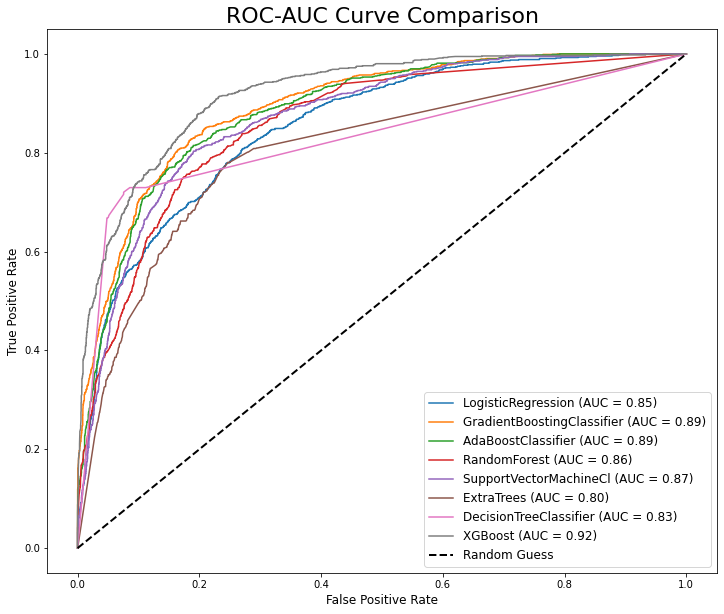

In [43]:
roc_curve_plotter(init_dict)

### Shap

In [37]:
import shap
shap_values = shap.TreeExplainer(xgb).shap_values(X_train)
shap.summary_plot(shap_values, X_train, plot_type="bar")

Exception: Model type not yet supported by TreeExplainer: <class 'module'>